## About
This notebook performs the comparison of 133 average $R_g$ values taken from the literature with a number of different tools for $R_g$ prediction.

### Deep learning based predictors
* STARLING (this work) (including CUDA vs. MPS based implementations, and checking reproduciblity across independent prediction runs)
* ALBATROSS - a deep-learning based predictor of average Rg values (note ALBATROSS uses an LSTM-BRNN implementation) as reported by [Lotthammer, Ginell, Griffith et al. 2024](https://www.nature.com/articles/s41592-023-02159-5))
* IDPGan – a generative adversarial network (GAN) that uses a transformer architecture trained on coarse-grained simulations of intrinsically disordered peptides, a as reported by [Janson et al. 2023](https://www.nature.com/articles/s41467-023-36443-x).

### Simulation-derived values
* CALVADOS2 ($R_g$ values from coarse-grained simulations as reported by [Tesei et al. 2022](https://open-research-europe.ec.europa.eu/articles/2-94))
* Mpipi-GG ($R_g$ values from coarse-grained simulations as reported by [Lotthammer, Ginell, Griffith et al. 2024](https://www.nature.com/articles/s41592-023-02159-5)). Note that Mpipi-GG is VERY closely based on the Mpipi forcefield as reported by [Joseph and Reinhardt et al 2021](https://www.nature.com/articles/s43588-021-00155-3).

### Model-based values
* AFRC (a null model reported by [Altson & Ginell et al. 2022](https://pubs.acs.org/doi/full/10.1021/acs.jpcb.3c01619?casa_token=7FU3SE0In7AAAAAA%3AEsuQZBw4VAjsDiRx6okDn1mQeh7KXPWUNDiEx0stVyD7XieqvjswLiT77VY-MQchbXnm9eno4EH-kICv))


In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm
from scipy.optimize import curve_fit

import matplotlib as mpl

mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.pad'] = 1

mpl.rcParams['xtick.major.size'] = 2  # Major tick length for x-axis
mpl.rcParams['xtick.minor.size'] = 0.5   # Minor tick length for x-axis
mpl.rcParams['ytick.major.size'] = 2  # Major tick length for y-axis
mpl.rcParams['ytick.minor.size'] = 0.5   # Minor tick length for y-axis

mpl.rcParams['xtick.major.width'] = 0.375  # Major tick width for x-axis
mpl.rcParams['ytick.major.width'] = 0.375  # Major tick width for y-axis
mpl.rcParams['xtick.minor.width'] = 0.375  # Major tick width for x-axis
mpl.rcParams['ytick.minor.width'] = 0.375  # Major tick width for y-axis

# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.375
tqdm
# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

In [2]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sparrow import Protein
from scipy.signal import savgol_filter

import protfasta
from starling import load_ensemble
import pandas as pd

## Notebook functions
The functions below define functions used through the notebook

In [3]:
def rmse(d1,d2):
    """
    Returns the root-mean-squared (RMSE) between two 
    vectors.

    Parameters
    -----------
    d1 : np.ndarray or list
        1D array with one set of values

    d2 : np.ndarray or list
        1D array with another set of values

    Returns
    -----------
    float
        Returns the RMSE     
    
    """

    if len(d1) != len(d2):
        raise ValueError('Input vectors must be same length')
    
    return np.sqrt(np.mean((np.array(d1) - np.array(d2))**2))



def get_histogram_vals(ens, 
                       method_name='radius_of_gyration', 
                       bw=1, 
                       wl=5, 
                       polyorder=2,
                       xmin=0,
                       xmax=100):
    """
    Returns a nice looking histogram for easy plotting of distributions.

    Parameters
    ----------
    ens : starling.Ensemble
        A starling Ensemble.
    method_name : str
        The name of the method to call on `ens`.
    bw : int, optional
        Bandwidth for histogram smoothing, default is 1.
    wl : int, optional
        Window length for smoothing, default is 5.
    polyorder : int, optional
        Polynomial order for smoothing, default is 2.
    
    Returns
    -------
    result : tuple
        return tuple with 
        [0] x-value bin positions [bin centers]
        [1] original histogram counts
        [2] smoothed counts
    """

    method = getattr(ens, method_name, None)
    if method is None or not callable(method):
        raise ValueError(f"Method '{method_name}' not found on the Ensemble object.")


    #vals = ens.radius_of_gyration()

    # get our values as defined by the Ensemble method
    vals = method()
    
    # define the bins to use for histograming
    bins = np.arange(xmin, xmax, bw)

    # construct histogram
    [a,b]= np.histogram(vals,bins=bins)

    # smooth the histogram counts, setting any values <0 to 0.
    smoothed = savgol_filter(a,wl,polyorder)
    smoothed[smoothed<0]=0

    # return tuple with (x-value bin positions [bin centers]), original histogram counts, smoothed counts)
    return b[1:]-bw*0.5, a, smoothed


def make_figure(d1, d2, xlabel, ylabel, outname, xymin=5, xymax=80, rmse_pos=[12,70],r2_pos=[12,60]):
    """
    Generates and saves a scatter plot comparing two sets of radius of gyration (Rg) values.

    This function creates a consistent figure style for comparing two datasets (d1 and d2)
    using a scatter plot with a diagonal reference line, RMSE annotation, and R² annotation.

    Parameters
    ----------
    d1 : array-like
        First dataset of Rg values (e.g., experimental or reference values).
    d2 : array-like
        Second dataset of Rg values (e.g., predicted or computed values).
    xlabel : str
        Label for the x-axis.
    ylabel : str
        Label for the y-axis.
    outname : str
        Filename (including extension) where the figure will be saved.
    xymin : float, optional
        Minimum value for both x- and y-axis (default is 5).
    xymax : float, optional
        Maximum value for both x- and y-axis (default is 80).
    rmse_pos : list of float, optional
        Coordinates [x, y] for displaying the RMSE annotation (default is [12, 70]).
    r2_pos : list of float, optional
        Coordinates [x, y] for displaying the R² annotation (default is [12, 60]).

    Notes
    -----
    - The function assumes `rmse(d1, d2)` is defined elsewhere and computes the root mean square error.
    - The function computes the coefficient of determination (R²) using Pearson correlation squared.
    - The figure is saved at high resolution (250 DPI) with a size of 2.5 x 2.5 inches.

    Example
    -------
    >>> make_figure(d1, d2, "Experimental Rg", "Predicted Rg", "comparison.pdf")
    """
    
    figure(None, (2.5,2.5), dpi=250)
    
    plt.plot(d1, d2,'ok', ms=3, mew=0, alpha=0.4)
    
    plt.plot([xymin,xymax],[xymin,xymax],'--r', lw=0.4)
    plt.xlabel(xlabel,fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.xlim([xymin,xymax])
    plt.ylim([xymin,xymax])
    
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    
    ccc = rmse(d1,d2)
    r2 = np.power(np.corrcoef(d1,d2)[0][1],2)
    
    plt.text(rmse_pos[0], rmse_pos[1], r"RMSE " +f" = {round(ccc,2)}", fontsize=6)
    plt.text(r2_pos[0], r2_pos[1], r"r$\rm{^2}$ " +f" = {round(r2,3)}", fontsize=6)
    plt.tight_layout()
    plt.savefig(outname)


In [4]:
# read in the pre-existing experimental/model data we generated using
# the sequence_generation.ipynb script
df = pd.read_csv('starling_comparison_data.csv', delimiter=',')  

# read in the names of sequences we have ensembles for
all_sequences = protfasta.read_fasta('all_comparison_seqs.fasta')
ordered_names = list(all_sequences.keys())


### MPS vs. CUDA vs. CPU
The cells below load in ensembles generated either using Apple silicon (Metal Performance Shader, MPS) or CUDA. This is to ensure the device used has no impact on the values obtained. We 

In [6]:
# initialize some dictionaries we'll store the ensembles in
mps_ensembles = {}
cuda1_ensembles = {}
cuda2_ensembles = {}

# define the rg values for plotting
cuda1_rg = []
cuda2_rg = []
mps_rg = []

# define the re values for plotting
cuda1_re = []
cuda2_re = []
mps_re = []


# leave this on, but in principle if we didn't want to plot CUDA data can turn it off...
LOAD_CUDA = True
# takes < 10 seconds to load from an SSD
for n in tqdm(ordered_names):
    
    
    mps  = load_ensemble(f'ensembles/mps/{n}.starling')

    if LOAD_CUDA:
        cuda1 = load_ensemble(f'ensembles/cuda_rep1/{n}.starling')
        cuda2 = load_ensemble(f'ensembles/cuda_rep2/{n}.starling')

        cuda1_rg.append(cuda1.radius_of_gyration(return_mean=True))
        cuda2_rg.append(cuda2.radius_of_gyration(return_mean=True))

        cuda1_re.append(cuda1.radius_of_gyration(return_mean=True))
        cuda2_re.append(cuda2.radius_of_gyration(return_mean=True))

        cuda1_ensembles[n] = cuda1
        cuda2_ensembles[n] = cuda2

    

    
    
    mps_rg.append(mps.radius_of_gyration(return_mean=True))    
    mps_re.append(mps.radius_of_gyration(return_mean=True))
    mps_ensembles[n] = mps
    
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:13<00:00,  9.53it/s]


In [25]:
# now we extract out other Rg data from the dataframe into the incredo
all_saxs_data = list(df['SAXS Rg (A)'])
all_calvados_data = df['CALVADOS2 Rg (A) [sim]']
all_mpipigg_data = df['Mpipi-GG (A) [sim]']
all_albatross = df['ALBATROSS Rg (A) [pred]']
all_idpgan = df['IDPGan Rg (A) [pred]']
all_afrc = df['AFRC Rg (A) [polymer model]']


starling_error = 100*((np.array(mps_rg) - np.array(all_saxs_data))/np.array(all_saxs_data))
calvados_error = 100*((np.array(all_calvados_data) - np.array(all_saxs_data))/np.array(all_calvados_data))
mpipi_error = 100*((np.array(all_mpipigg_data) - np.array(all_saxs_data))/np.array(all_mpipigg_data))
albatross_error = 100*((np.array(all_albatross) - np.array(all_saxs_data))/np.array(all_albatross))
idpgan_error = 100*((np.array(all_idpgan) - np.array(all_saxs_data))/np.array(all_idpgan))
afrc_error = 100*((np.array(all_afrc) - np.array(all_saxs_data))/np.array(all_afrc))

rmse_percent_mpipi      = np.sqrt(np.mean(np.power(mpipi_error,2)))
rmse_percent_starling  = np.sqrt(np.mean(np.power(starling_error,2)))
rmse_percent_calvados  = np.sqrt(np.mean(np.power(calvados_error,2)))
rmse_percent_albatross = np.sqrt(np.mean(np.power(albatross_error,2)))
rmse_percent_idpgan    = np.sqrt(np.mean(np.power(idpgan_error,2)))
rmse_percent_afrc      = np.sqrt(np.mean(np.power(afrc_error,2)))

print(f"RMSE percentage error for CALVADOS2 : {round(rmse_percent_calvados,2)}%")
print(f"RMSE percentage error for ALBATROSS : {round(rmse_percent_albatross,2)}%")
print(f"RMSE percentage error for Mpipi-GG  : {round(rmse_percent_mpipi,2)}%")
print(f"RMSE percentage error for STARLING  : {round(rmse_percent_starling,2)}%")
print(f"RMSE percentage error for AFRC      : {round(rmse_percent_afrc,2)}%")
print(f"RMSE percentage error for IDPGan    : {round(rmse_percent_idpgan,2)}%")


RMSE percentage error for CALVADOS2 : 9.49%
RMSE percentage error for ALBATROSS : 11.13%
RMSE percentage error for Mpipi-GG  : 11.2%
RMSE percentage error for STARLING  : 12.67%
RMSE percentage error for AFRC      : 19.66%
RMSE percentage error for IDPGan    : 36.51%


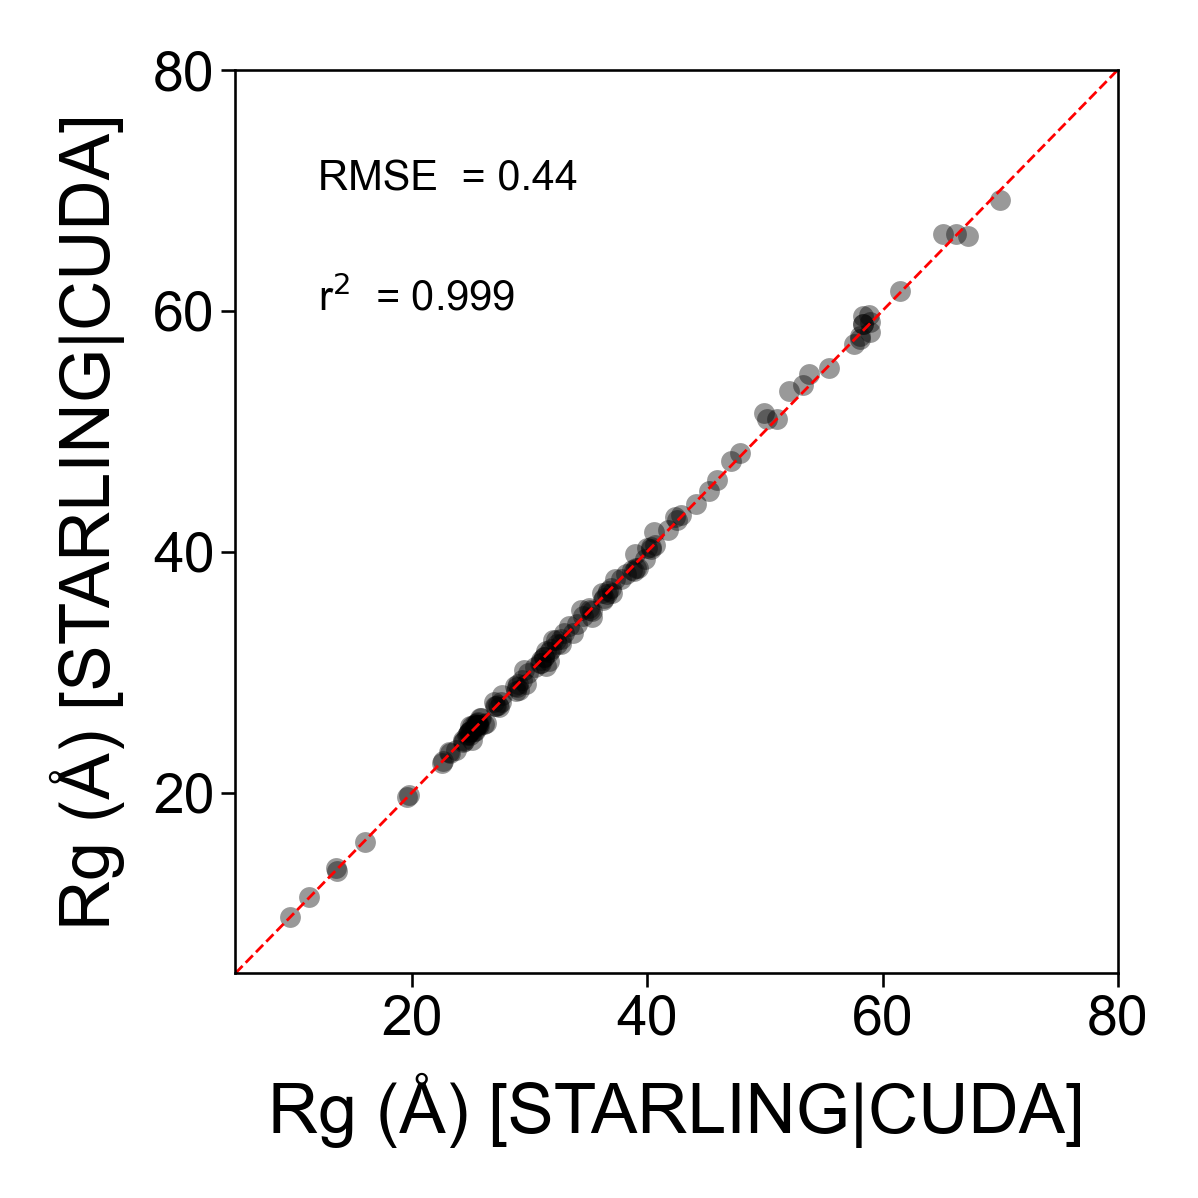

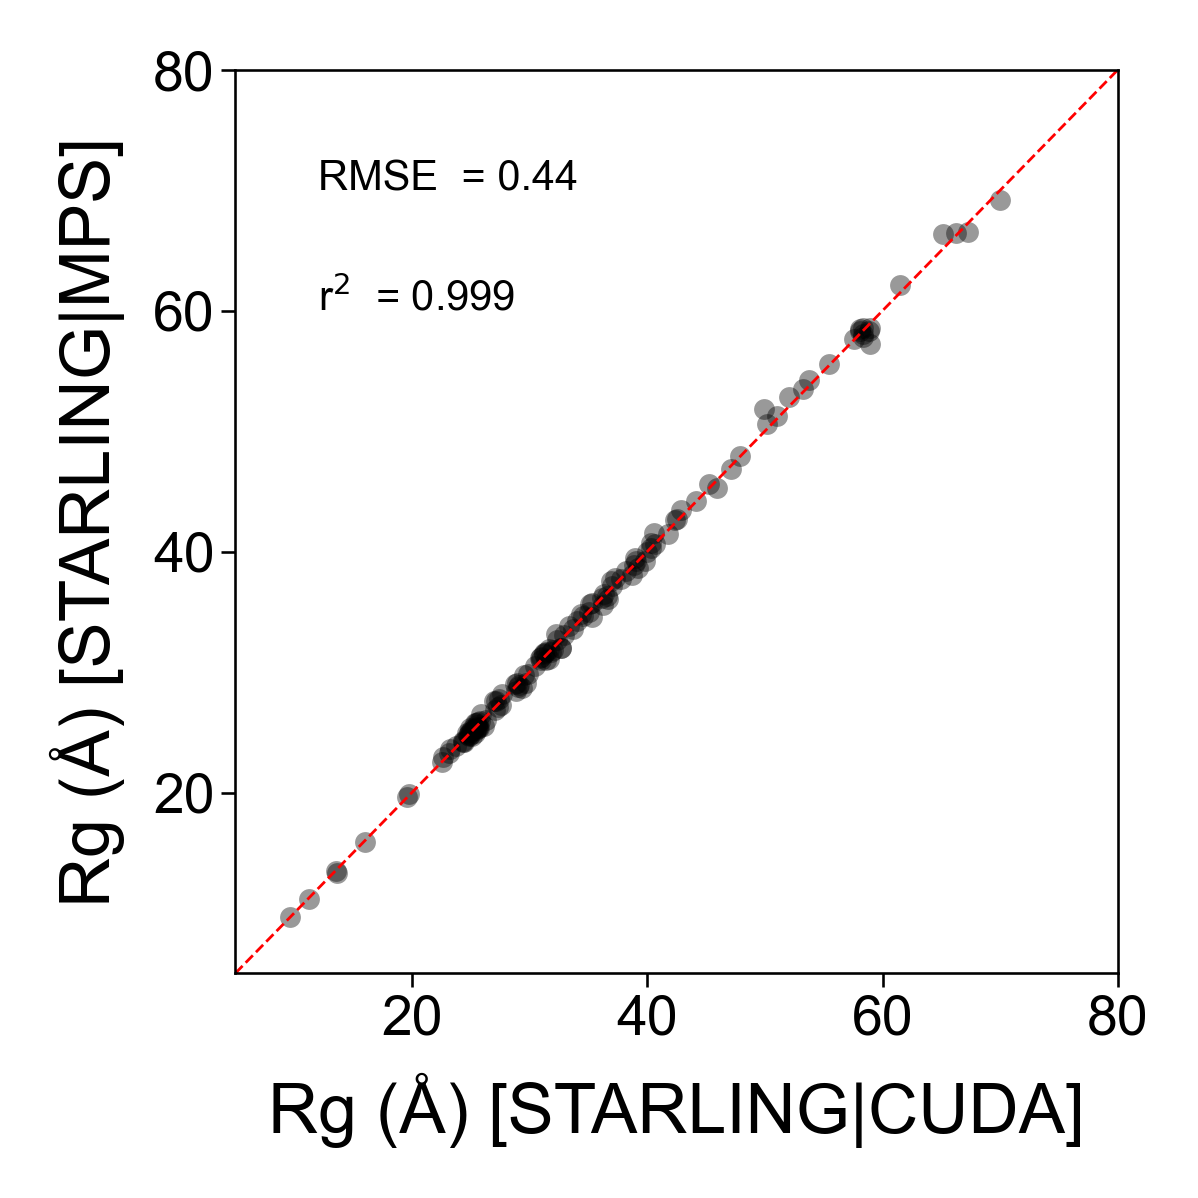

In [16]:
# compare two independent CUDA runs (first figure) and comapre CUDA vs. MPS predictions (second figure)
if LOAD_CUDA:
    make_figure(cuda1_rg, cuda2_rg, f"Rg (Å) [STARLING|CUDA]", f"Rg (Å) [STARLING|CUDA]", "figures/cuda_vs_cuda.pdf")
    make_figure(cuda1_rg, mps_rg, f"Rg (Å) [STARLING|CUDA]", f"Rg (Å) [STARLING|MPS]", "figures/cuda_vs_mps.pdf")


## Experiment vs. other methods

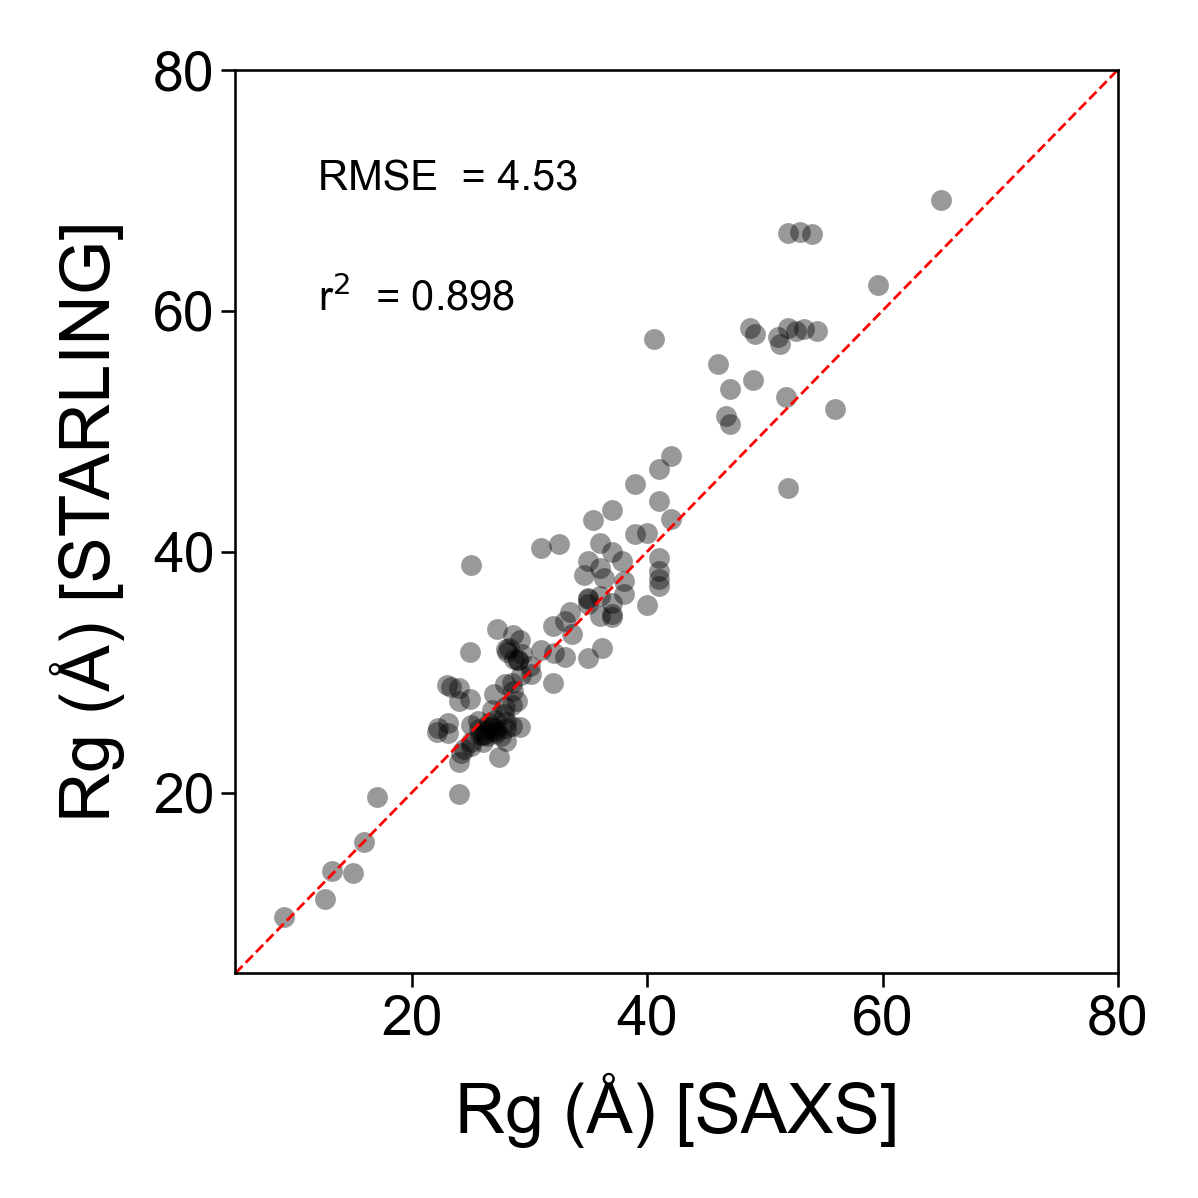

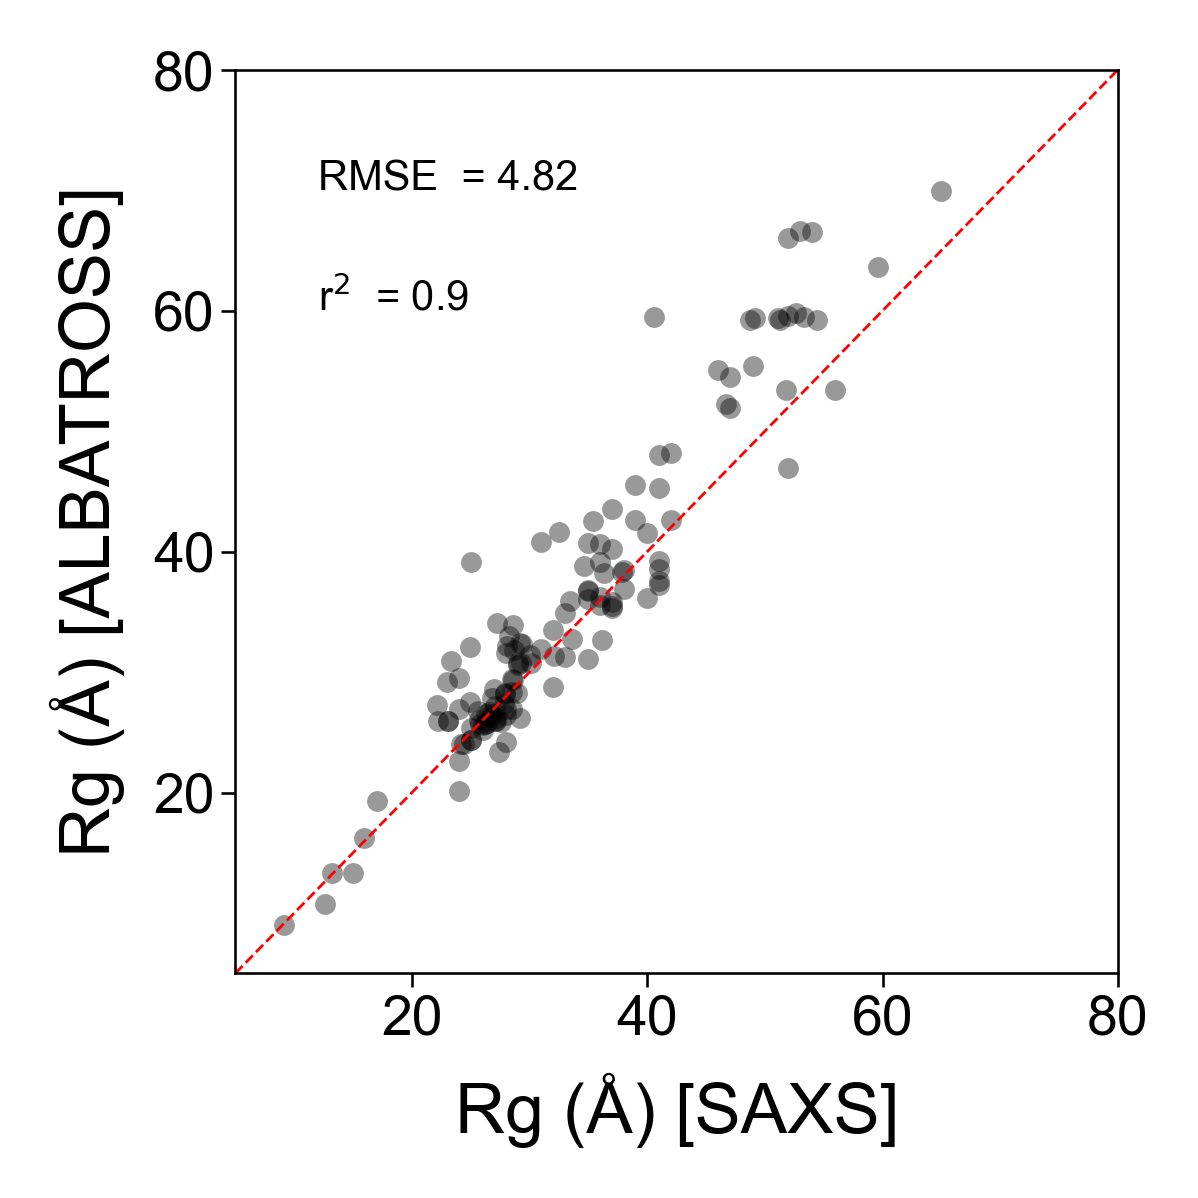

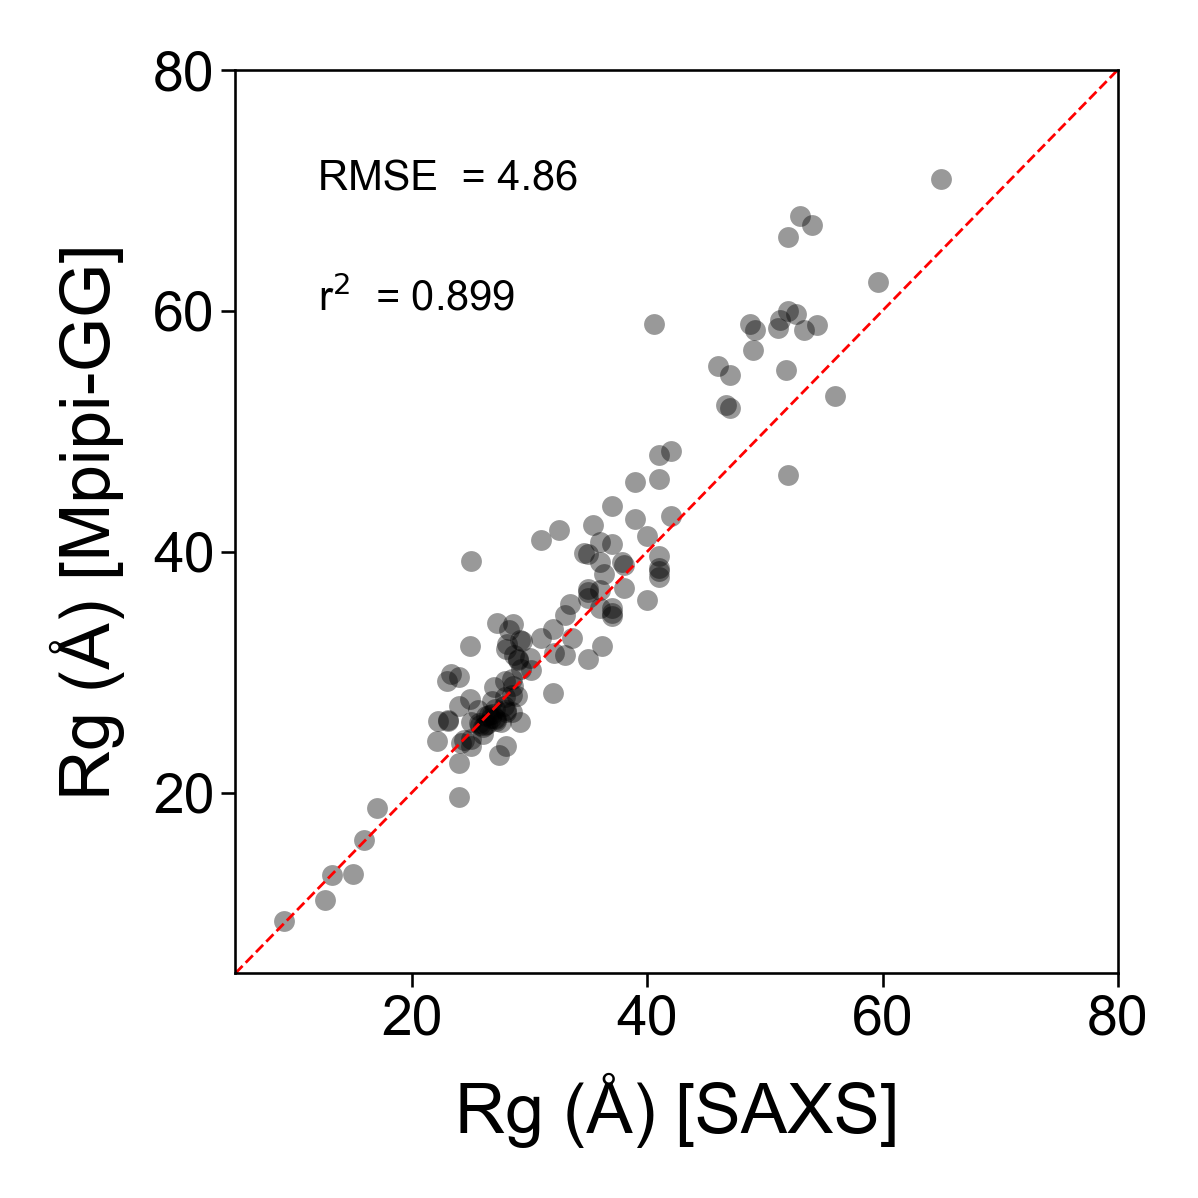

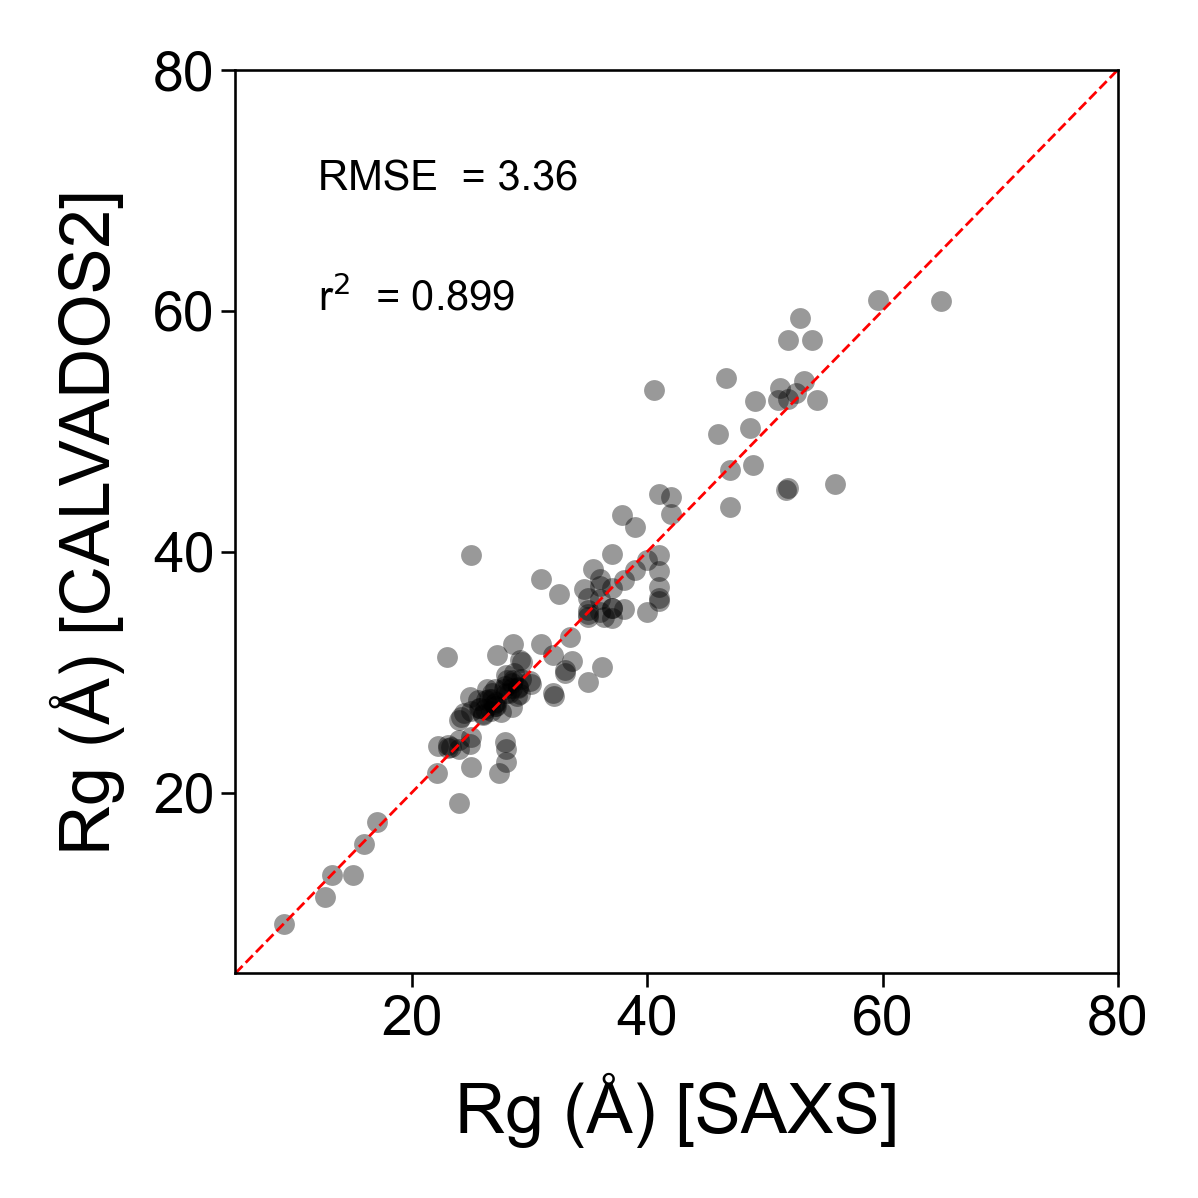

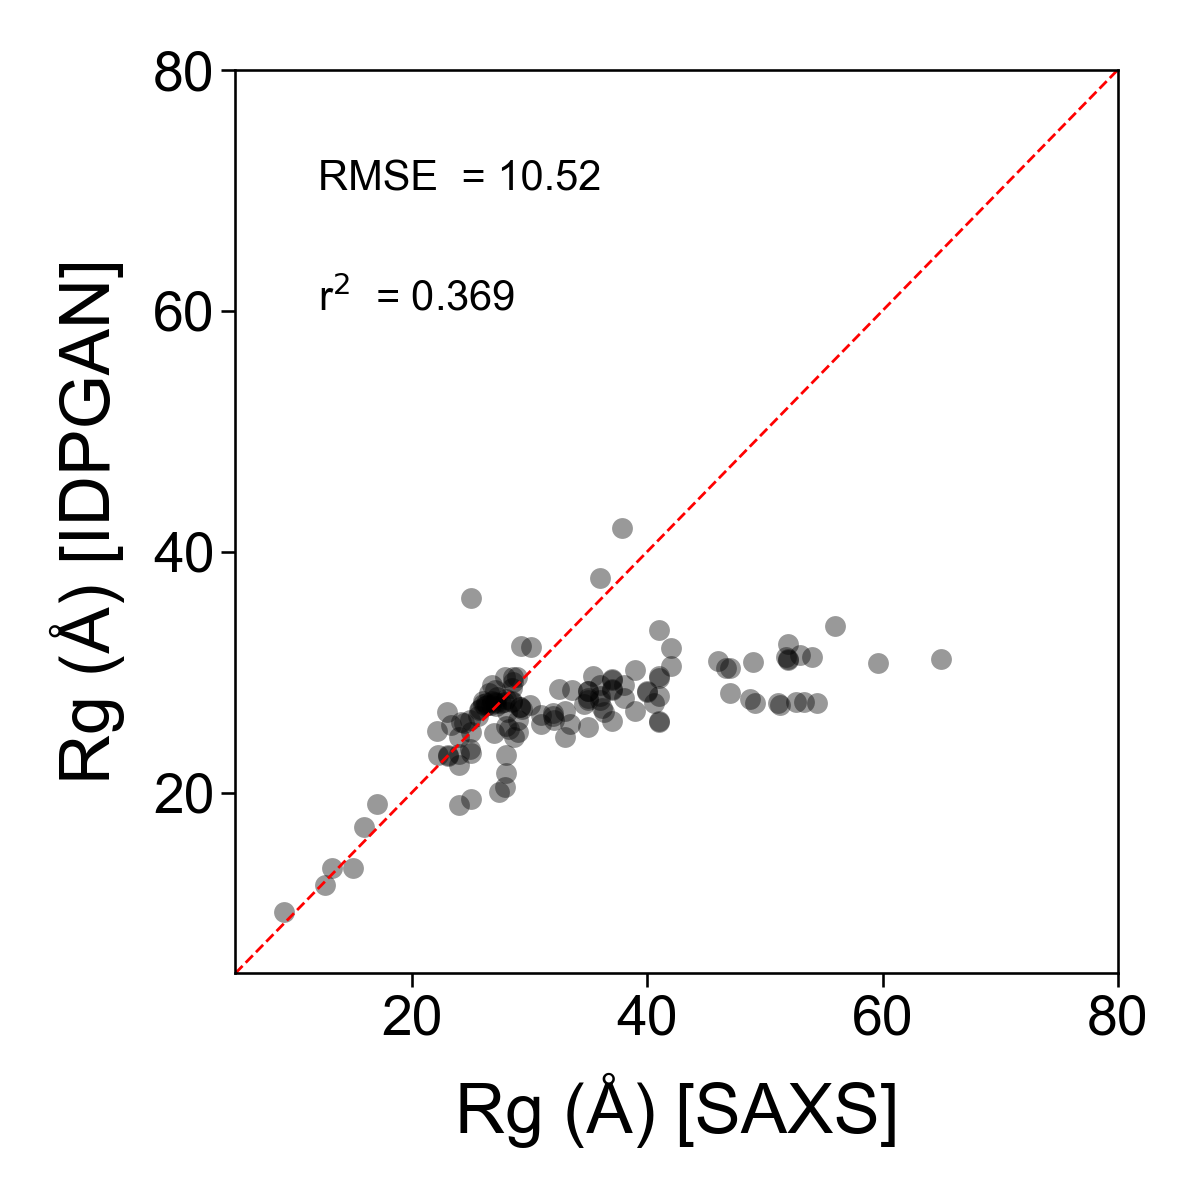

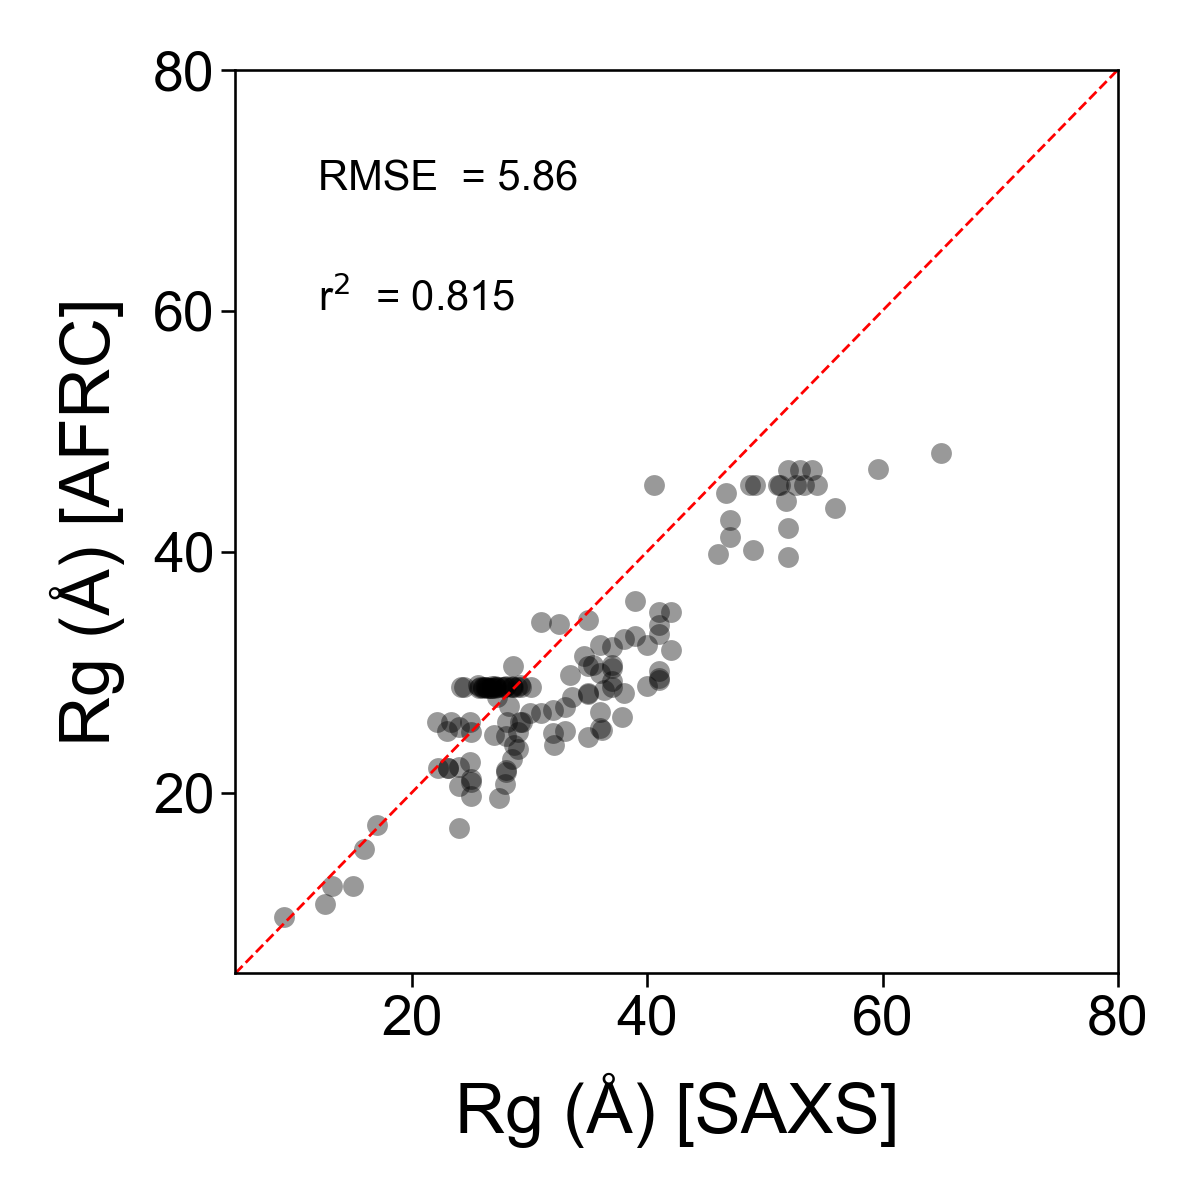

In [26]:
make_figure(all_saxs_data, mps_rg, f"Rg (Å) [SAXS]", f"Rg (Å) [STARLING]", "figures/saxs_vs_starling.pdf")
make_figure(all_saxs_data, all_albatross, f"Rg (Å) [SAXS]", f"Rg (Å) [ALBATROSS]", "figures/saxs_vs_ALBATROSS.pdf")
make_figure(all_saxs_data, all_mpipigg_data, f"Rg (Å) [SAXS]", f"Rg (Å) [Mpipi-GG]", "figures/saxs_vs_MpipiGG.pdf")
make_figure(all_saxs_data, all_calvados_data, f"Rg (Å) [SAXS]", f"Rg (Å) [CALVADOS2]", "figures/saxs_vs_CALVADOS2.pdf")
make_figure(all_saxs_data, all_idpgan, f"Rg (Å) [SAXS]", f"Rg (Å) [IDPGAN]", "figures/SAXS_vs_IDPGAN.pdf")
make_figure(all_saxs_data, all_afrc, f"Rg (Å) [SAXS]", f"Rg (Å) [AFRC]", "figures/saxs_vs_AFRC.pdf")


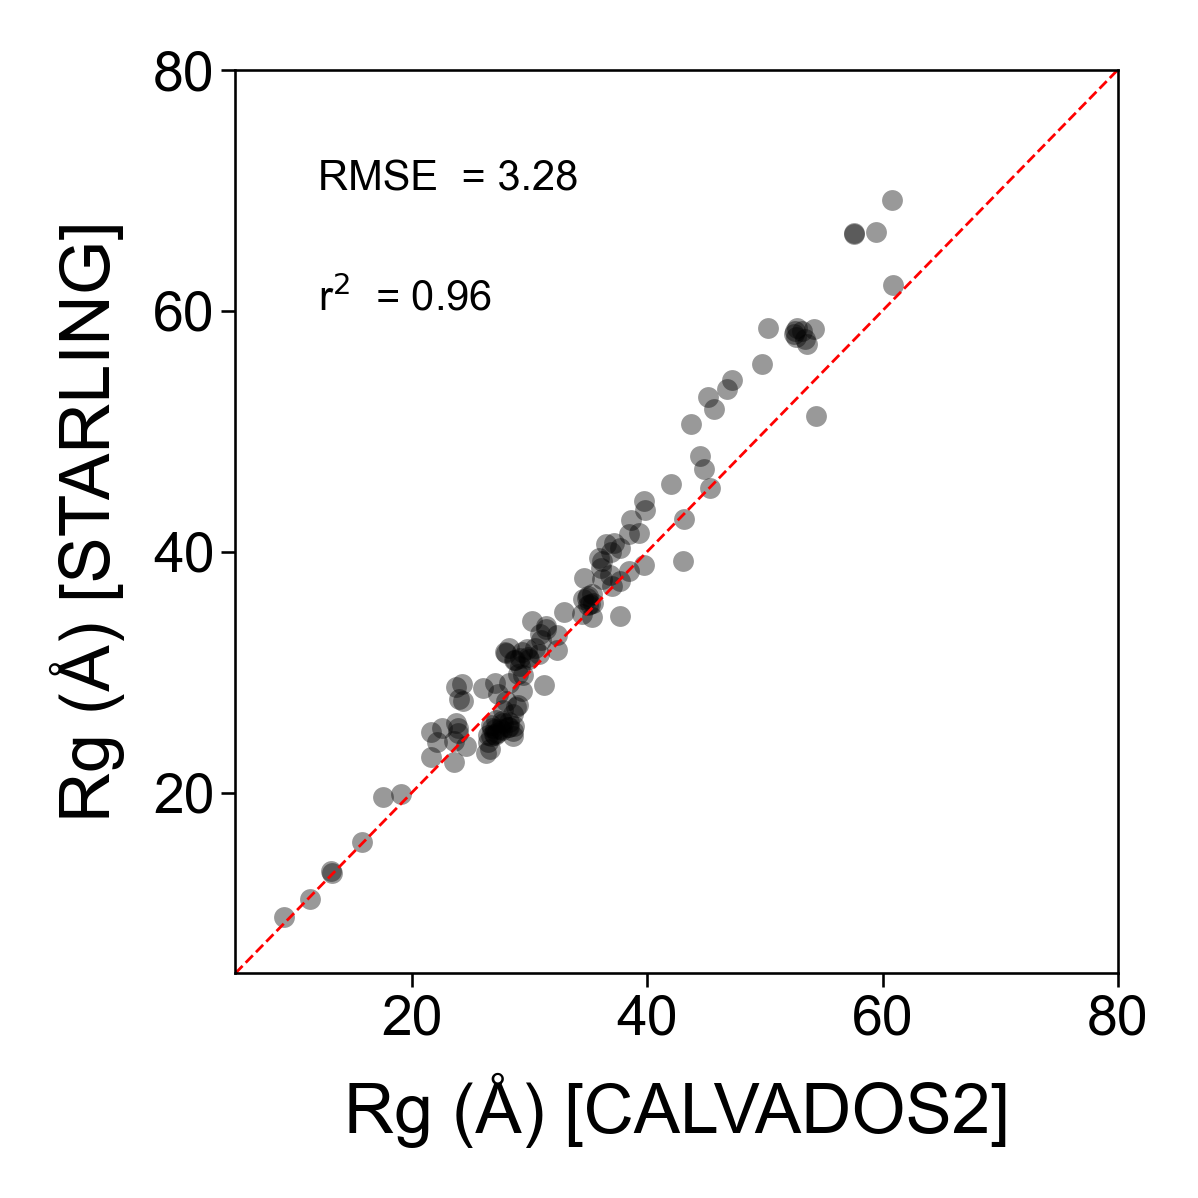

In [28]:
make_figure(all_calvados_data, mps_rg, f"Rg (Å) [CALVADOS2]", f"Rg (Å) [STARLING]", "figures/CALVADOS2_vs_STARLING.pdf")


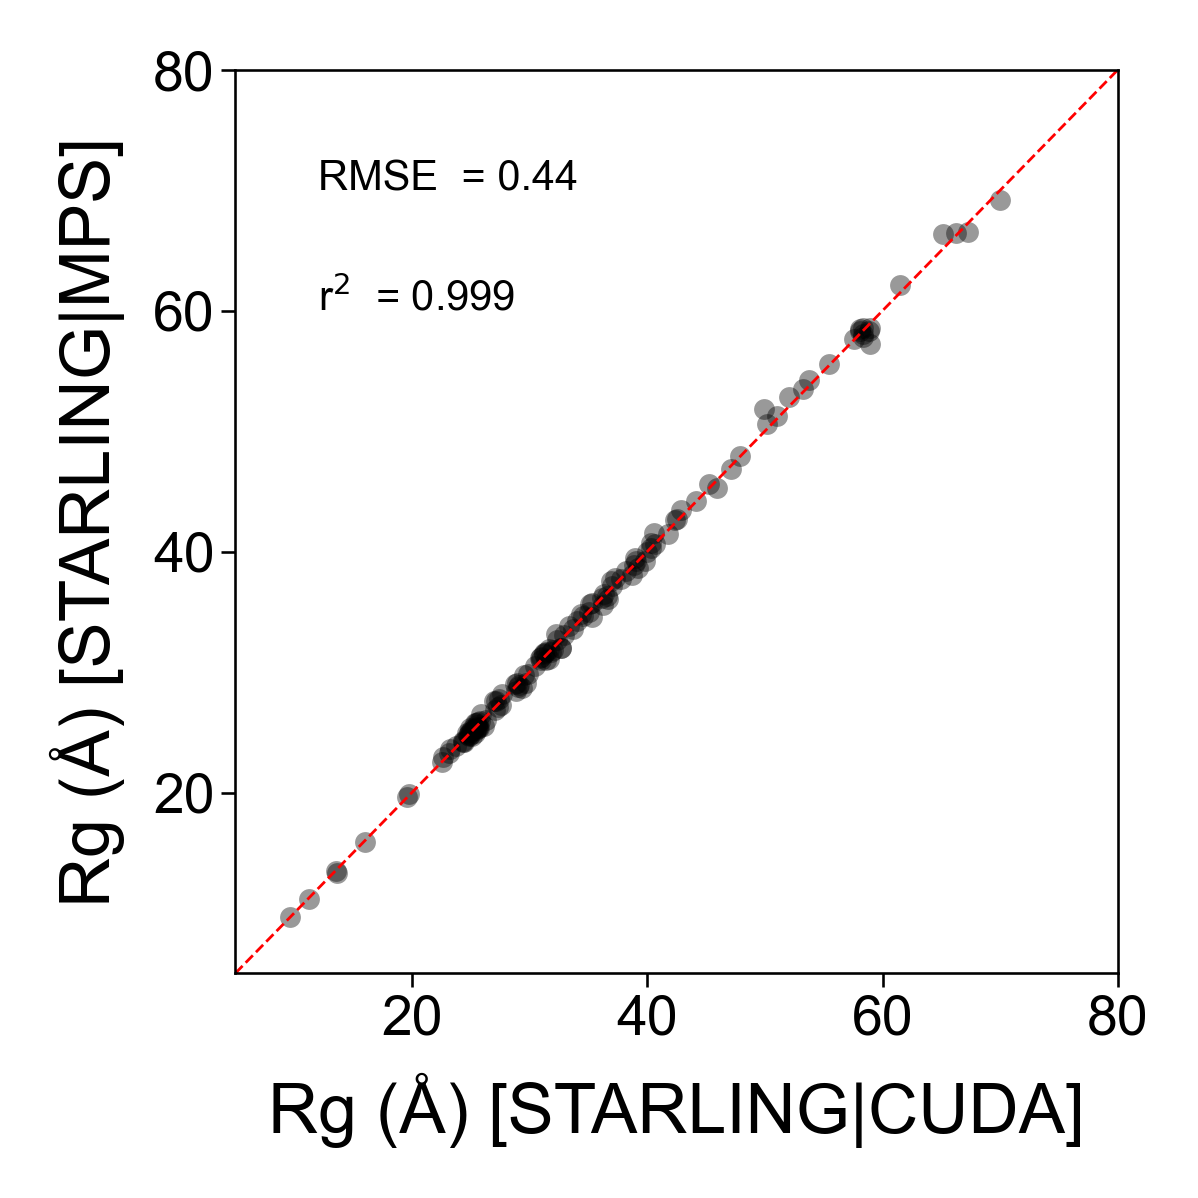

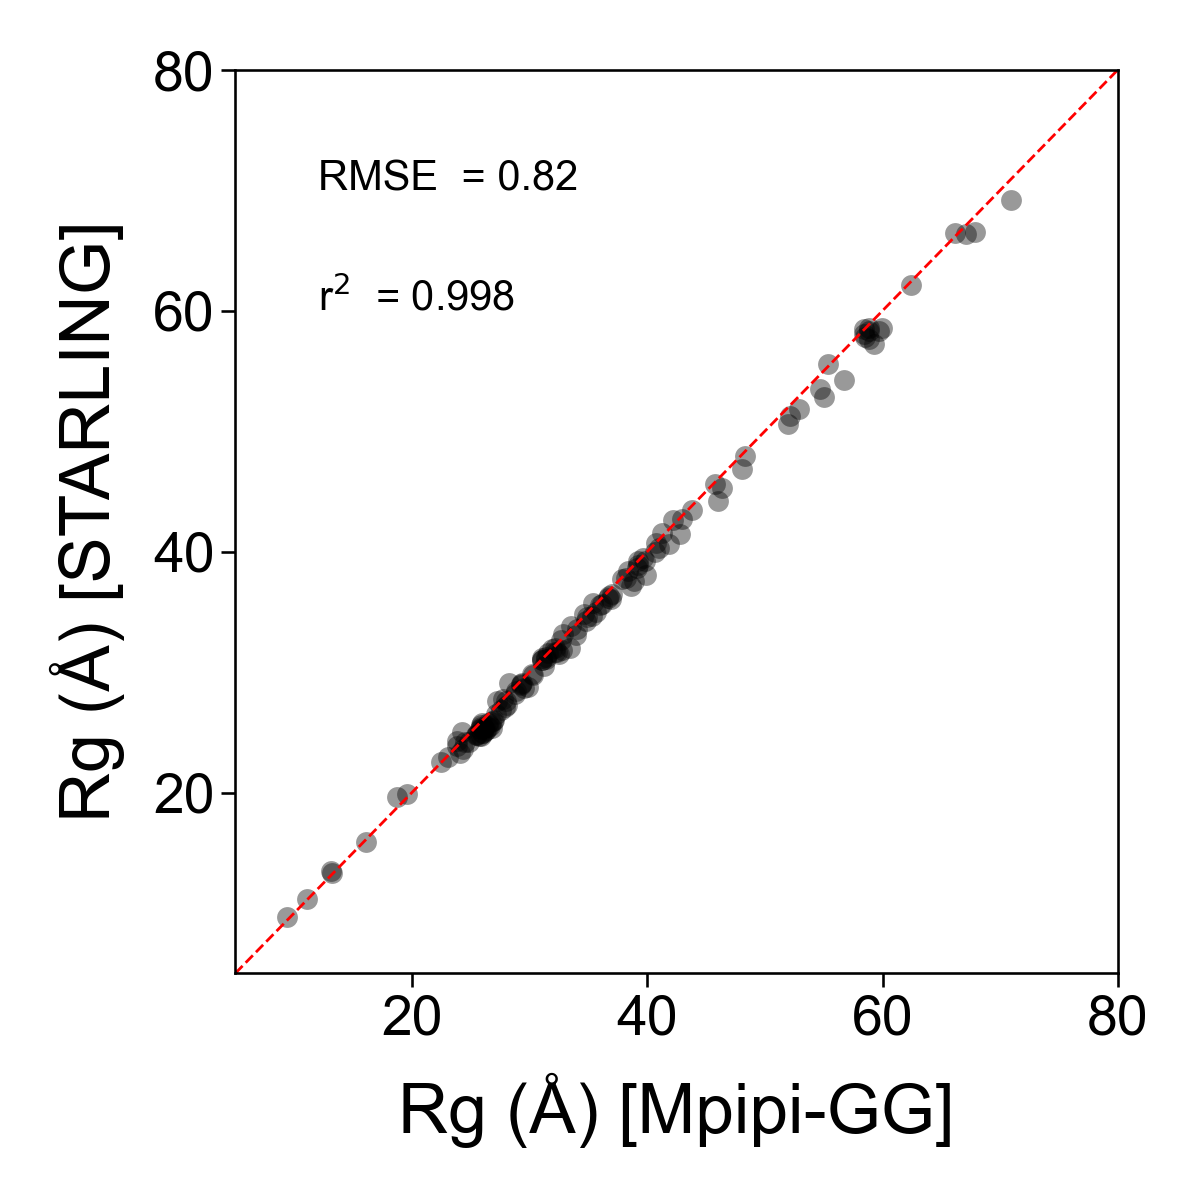

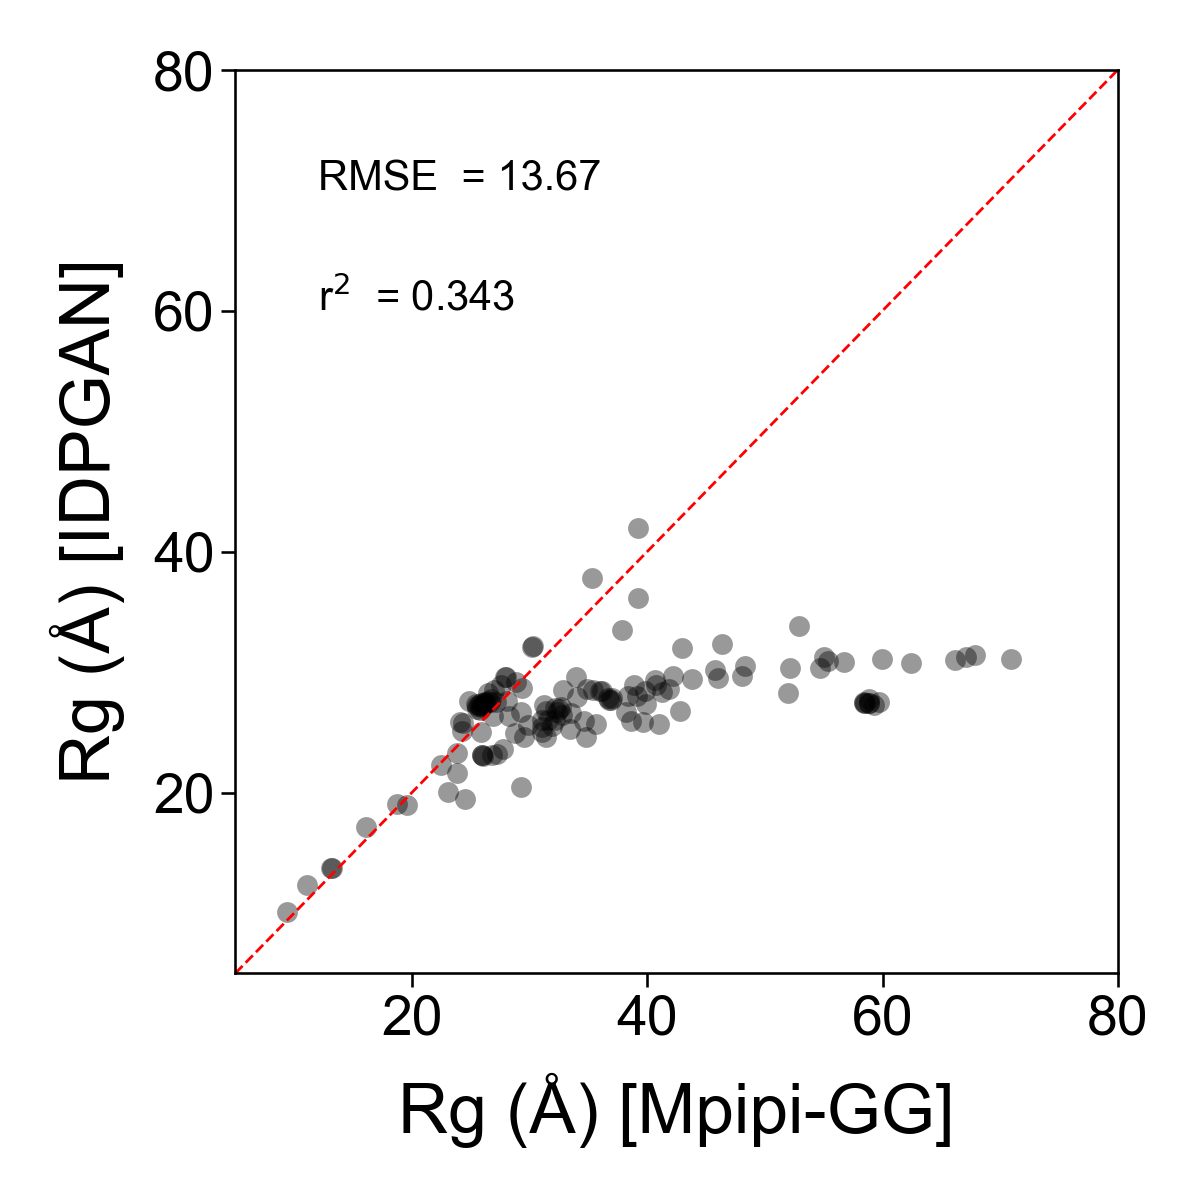

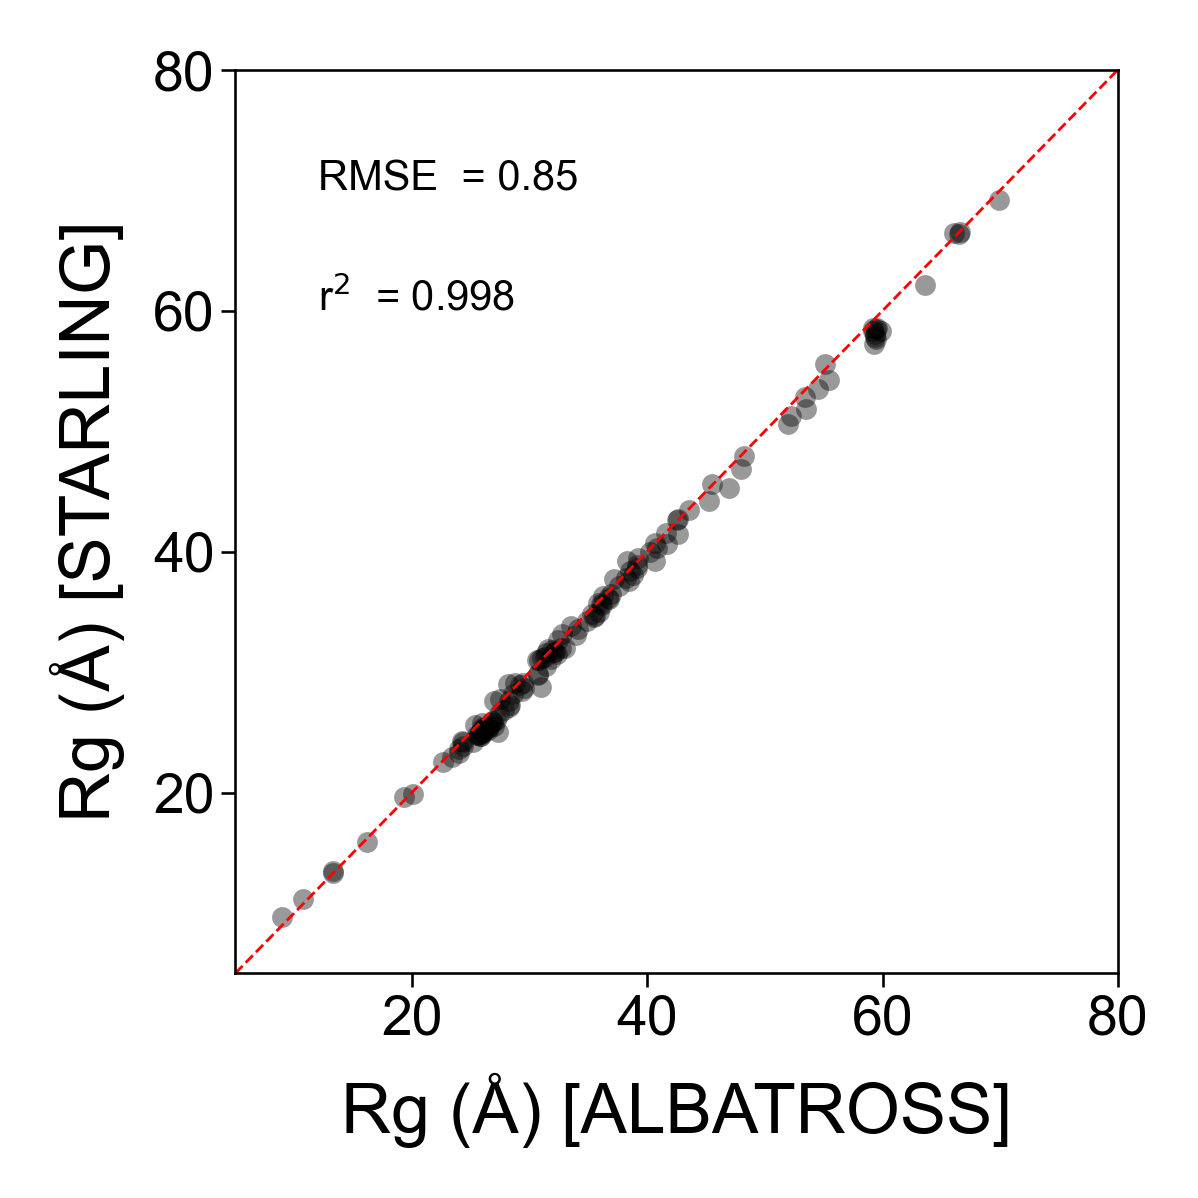

In [29]:
if LOAD_CUDA:

    # MPS vs. CUDA for STARLING
    make_figure(cuda1_rg, mps_rg, f"Rg (Å) [STARLING|CUDA]", f"Rg (Å) [STARLING|MPS]", "figures/cuda_vs_mps.pdf")

# Mpipi vs STARLING
make_figure(all_mpipigg_data, mps_rg, f"Rg (Å) [Mpipi-GG]", f"Rg (Å) [STARLING]", "figures/MpipiGG_vs_STARLING.pdf")

# Mpipi vs. IDPGan
make_figure(all_mpipigg_data, all_idpgan, f"Rg (Å) [Mpipi-GG]", f"Rg (Å) [IDPGAN]", "figures/MpipiGG_vs_IDPGAN.pdf")

# ALBATROSS vs. STARING
make_figure(all_albatross, mps_rg, f"Rg (Å) [ALBATROSS]", f"Rg (Å) [STARLING]", "figures/ALBATROSS_vs_STARLING.pdf")


In [17]:
seqs            = list(df['sequence'])
vals_saxs      = list(df['SAXS Rg (A)'])
vals_calvados  = df['CALVADOS2 Rg (A) [sim]']
vals_mpipigg   = df['Mpipi-GG (A) [sim]']
vals_idpsam    = df['IDPGan Rg (A) [pred]']
vals_afrc      = df['AFRC Rg (A) [polymer model]']
vals_albatross = df['ALBATROSS Rg (A) [pred]']
vals_starlingmps  = mps_rg
vals_starlingcuda = cuda1_rg


In [18]:
with open('data_out/all_comparison_data_WITH_STARTING.csv','w') as fh:

    fh.write('name, saxs, starling_mps, starling_cuda, albatross, mpipigg, calvados, afrc, idpsam, sequence\n')
    for i in range(len(ordered_names)):
        name = ordered_names[i]
        _seq = seqs[i]
    
        # check nothing weird has happened...
        assert all_sequences[name] == _seq
        fh.write(f'{name}, {vals_saxs[i]}, {round(vals_starlingmps[i],2)}, {round(vals_starlingcuda[i],2)}, {vals_albatross[i]}, {vals_mpipigg[i]}, {vals_calvados[i]}, {vals_afrc[i]}, {vals_idpsam[i]}, {_seq}\n')
